## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94105,00023905_000.png,No Finding,0,23905,31,F,PA,2048,2500,0.168,0.168,NaN,/data/images_010/images/00023905_000.png
104687,00028034_002.png,No Finding,2,28034,15,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00028034_002.png
48041,00012164_001.png,Effusion|Infiltration,1,12164,41,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012164_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: '1' if pathology in x else '0')

In [4]:
all_xray_df.head()
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# how many classes with pneumonia
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule',
       'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema',
       'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia'],
      dtype='object')

## Create your training and testing data:

In [6]:
def create_splits():
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data,val_data = train_test_split(all_xray_df,test_size=.2,stratify=all_xray_df['Pneumonia'])
    # verfiy train/val split
    
    
    return train_data, val_data
train_data,val_data = create_splits()

In [7]:

# size of val_data for positive cases
train_data['Pneumonia'].astype('int').sum()/len(train_data)

    


0.012765340706386016

In [8]:
val_data['Pneumonia'].astype('int').sum()/len(val_data)

0.012754191937210132

In [9]:
from random import sample
p_inds = train_data[train_data.Pneumonia=='1'].index.tolist()
np_inds = train_data[train_data.Pneumonia=='0'].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [10]:
len(train_data)

2290

In [11]:
len(train_data[train_data.Pneumonia=='1'])

1145

In [12]:
train_data['Pneumonia'].astype('int').sum()/len(train_data)

0.5

In [13]:
p_inds = val_data[val_data.Pneumonia=='1'].index.tolist()
np_inds = val_data[val_data.Pneumonia=='0'].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,len(4*p_inds))
val_data = val_data.loc[p_inds + np_sample]

In [14]:
val_data['Pneumonia'].astype('int').sum()/len(val_data)

0.2

In [15]:
len(val_data)

1430

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    
    return my_idg


def make_train_gen(vargs):
    
    
    my_train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                            featurewise_center=True, featurewise_std_normalization=True)
    #datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    #datagen.mean, datagen.std)
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory=None, 
                                        x_col = 'path',
                                        y_col = 'Pneumonia',
                                        target_size = IMG_SIZE,
                                        class_mode = 'binary',
                                        batch_size =9 
                                          )
    # get the mean and std deviation of the image generator to be used as the parameters in the inference
    print('Mean = ',my_train_idg.mean)
    print('std dev = ',my_train_idg.std)

    return train_gen


def make_val_gen(vargs):
    
  # Todo
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
                                 

    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                            class_mode = 'binary',
                                       
                                              target_size =IMG_SIZE , 
                                              batch_size =1430 ) 
    
   
    return val_gen
vargs = 5
train_gen = make_train_gen(vargs)
val_gen = make_val_gen(vargs)

Found 2290 validated image filenames belonging to 2 classes.
Mean =  None
std dev =  None
Found 1430 validated image filenames belonging to 2 classes.


In [17]:
val_gen

In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:


valX, valY = val_gen.next()

In [19]:
len(valY)

1430

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


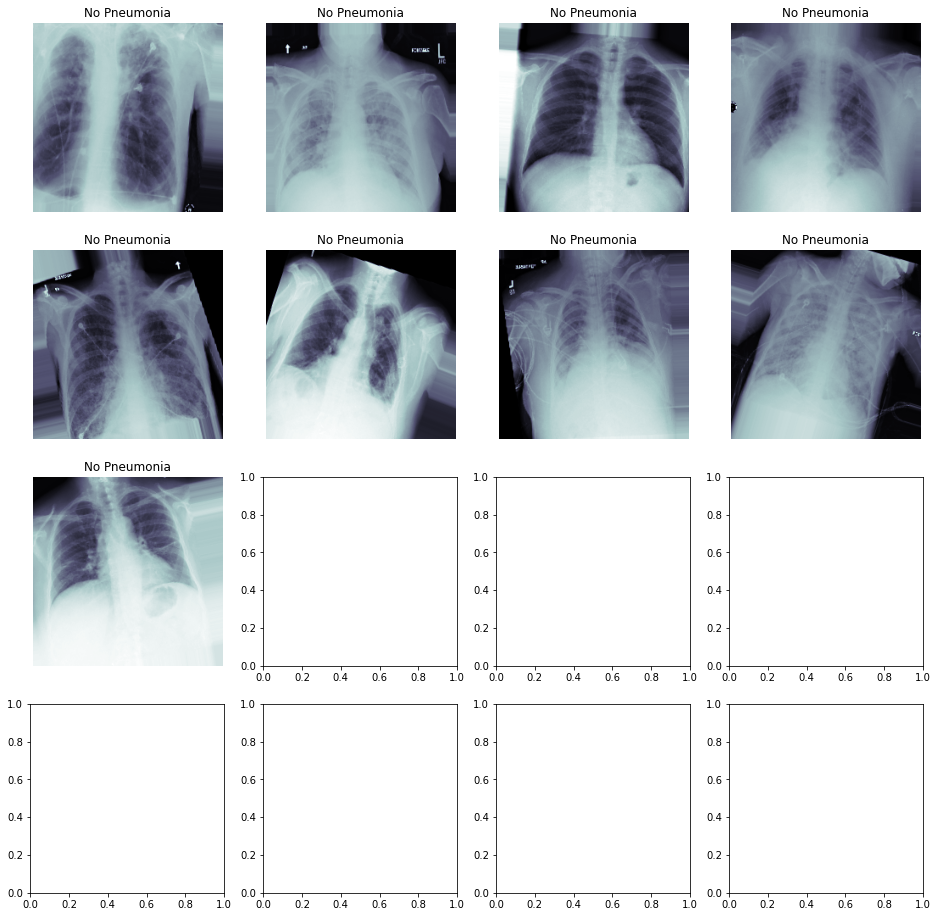

In [20]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 'Yes': 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [21]:
def load_pretrained_model(vargs):
    
      
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
   
    return vgg_model


In [22]:

vgg_model = load_pretrained_model(3)
vgg_model.summary()

def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
     
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    return new_model

my_model = build_my_model(1)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [23]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [24]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_accuracy', 
                            verbose=1, 
                            save_best_only=True, 
                            mode= 'max', 
                            save_weights_only = True)

early = EarlyStopping(monitor= 'val_accuracy', 
                       mode= 'max', 
                       patience=10)

callbacks_list = [checkpoint, early]


In [25]:
# complile the model
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training! 

In [26]:
## train your model

# Todo
import pickle
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX,valY), 
                          epochs = 20, callbacks = callbacks_list)
with open('./trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
my_model.save('./my_modeljay.hdf5');


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


255/255 [==============================] - 95s 372ms/step - loss: 0.7804 - binary_accuracy: 0.4983 - val_loss: 0.6352 - val_binary_accuracy: 0.6559
Epoch 2/20
  1/255 [..............................] - ETA: 42s - loss: 0.6707 - binary_accuracy: 0.5556

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


255/255 [==============================] - 80s 315ms/step - loss: 0.7034 - binary_accuracy: 0.5467 - val_loss: 0.6978 - val_binary_accuracy: 0.5266
Epoch 3/20
255/255 [==============================] - 80s 315ms/step - loss: 0.6885 - binary_accuracy: 0.5576 - val_loss: 0.5717 - val_binary_accuracy: 0.7273
Epoch 4/20
255/255 [==============================] - 80s 313ms/step - loss: 0.6770 - binary_accuracy: 0.5790 - val_loss: 0.5622 - val_binary_accuracy: 0.7434
Epoch 5/20
255/255 [==============================] - 80s 315ms/step - loss: 0.6752 - binary_accuracy: 0.5795 - val_loss: 0.6916 - val_binary_accuracy: 0.5804
Epoch 6/20
255/255 [==============================] - 80s 312ms/step - loss: 0.6588 - binary_accuracy: 0.6109 - val_loss: 0.5535 - val_binary_accuracy: 0.7287
Epoch 7/20
255/255 [==============================] - 80s 313ms/step - loss: 0.6630 - binary_accuracy: 0.6039 - val_loss: 0.6738 - val_binary_accuracy: 0.6091
Epoch 8/20
255/255 [==============================] - 79s

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
#my_model.load_weights(weight_path)
from keras.models import load_model
my_modelFromFile = load_model('./my_modeljay.hdf5')

pred_Y = my_modelFromFile.predict(valX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 19s 13ms/step


In [28]:
pred_Y

array([[0.2251234 ],
       [0.7902447 ],
       [0.19717988],
       ...,
       [0.46188557],
       [0.73124224],
       [0.1882424 ]], dtype=float32)

In [29]:
valY

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [30]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(valY, pred_Y)


In [31]:
# calculate AUC
auc = roc_auc_score(valY, pred_Y)
print('AUC: %.3f' % auc)

AUC: 0.693


In [32]:
valY

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [33]:
pred_Y

array([[0.2251234 ],
       [0.7902447 ],
       [0.19717988],
       ...,
       [0.46188557],
       [0.73124224],
       [0.1882424 ]], dtype=float32)

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    ## what other performance statistics do you want to include here besides AUC? 
    # Todo
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(t_y, p_y)
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_auc_score(t_y, p_y)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()
    
    return

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    #plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

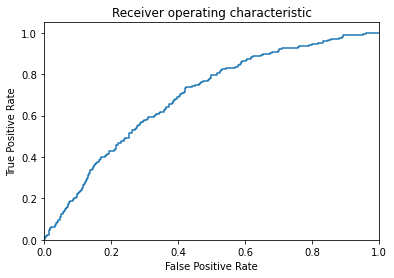

In [35]:
## plot figures



plot_auc(valY,pred_Y)

history = pickle.load(open('./trainHistoryDict', "rb"))


In [36]:
history

{'val_loss': [0.6352143130519173,
  0.6978392839848578,
  0.5717304895807813,
  0.5622149120677601,
  0.6915924253163638,
  0.5534530786159155,
  0.6738314196780011,
  0.7288058780706845,
  0.6963628921058628,
  0.6458512572975426,
  0.6836896183190646,
  0.6674370637098392,
  0.6386184454589457,
  0.6740885810001747,
  0.6166492496753906,
  0.6898804125252304,
  0.5549188986524836,
  0.6929072069955039,
  0.5948389399093348,
  0.6219983074006501],
 'val_binary_accuracy': [0.6559440493583679,
  0.5265734195709229,
  0.7272727489471436,
  0.7433566451072693,
  0.5804196000099182,
  0.7286713123321533,
  0.6090909242630005,
  0.5888111591339111,
  0.5860139727592468,
  0.6587412357330322,
  0.59300696849823,
  0.6237761974334717,
  0.6622377634048462,
  0.6209790110588074,
  0.6671328544616699,
  0.5986014008522034,
  0.7181817889213562,
  0.618881106376648,
  0.6790210008621216,
  0.6804195642471313],
 'loss': [0.7803727404259178,
  0.7036752464989908,
  0.688782091965842,
  0.677063139

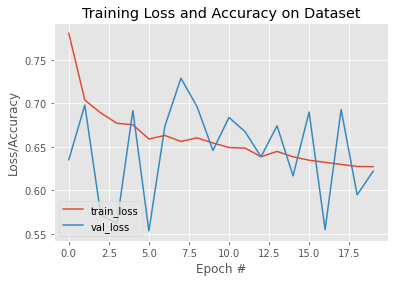

In [37]:
    N = len(history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history["val_loss"], label="val_loss")
    #plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    #plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [38]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

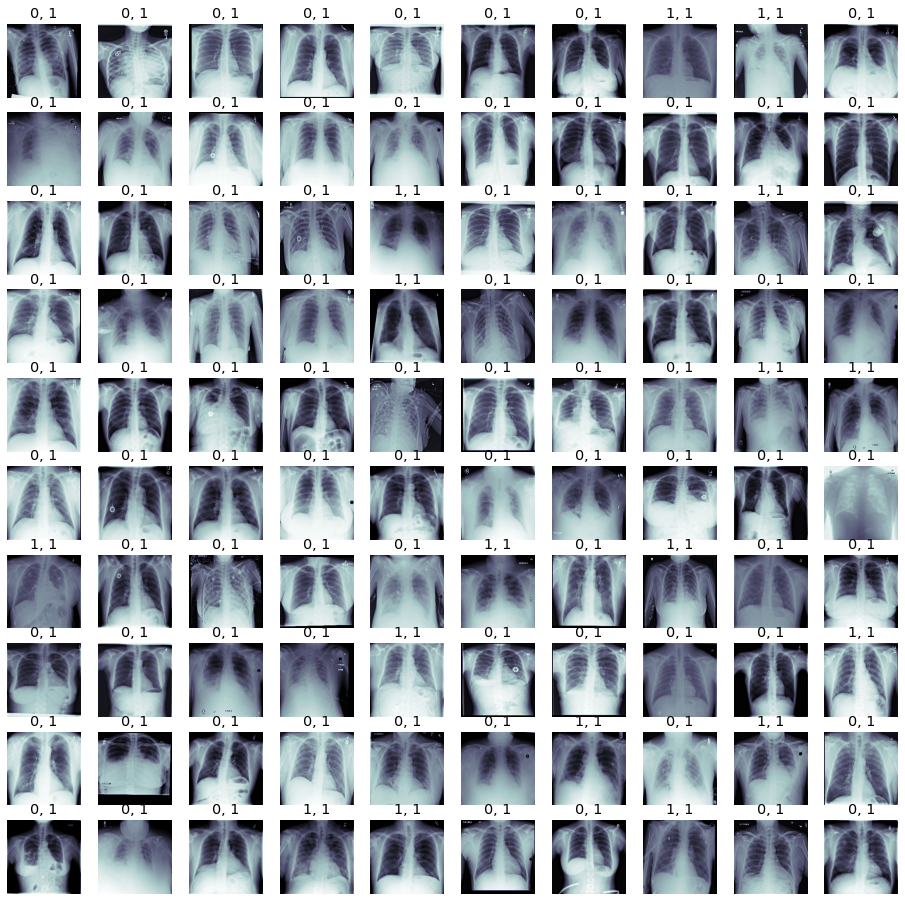

In [39]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1


YOUR_THRESHOLD=.05
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
            if pred_Y[i] > YOUR_THRESHOLD:
                 c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [40]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
    
my_model.save_weights("myjaymodel.h5")

In [41]:
# saving valy and predy so i can get out of gpu
import pandas as pd
valYDf = pd.DataFrame({"valy":valY})
valYDf.to_pickle("./valy.pkl")

In [42]:
pred_Y

array([[0.2251234 ],
       [0.7902447 ],
       [0.19717988],
       ...,
       [0.46188557],
       [0.73124224],
       [0.1882424 ]], dtype=float32)

In [43]:
pred_YDf = pd.DataFrame(pred_Y,columns=["predy"])
pred_YDf.to_pickle("./predy.pkl")

In [44]:
valY


array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [1]:
import pandas as pd
valY = pd.read_pickle("./valy.pkl")
predy = pd.read_pickle("./predy.pkl")

In [2]:
# Now we need to figure out the threshold correctly
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(valY, predy.predy)

In [3]:
precision, recall, thresholds

(array([0.20605187, 0.20547945, 0.20562771, ..., 0.5       , 1.        ,
        1.        ]),
 array([1.       , 0.9965035, 0.9965035, ..., 0.0034965, 0.0034965,
        0.       ]),
 array([0.15958677, 0.16086447, 0.16138053, ..., 0.90453756, 0.9327746 ,
        0.9354095 ], dtype=float32))

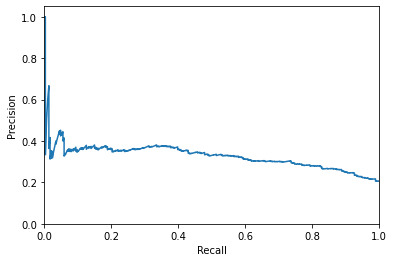

In [4]:
# Plot precision recall to pick the threshold
import matplotlib.pyplot as plt
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.plot(recall,precision)

In [11]:

# To find the right threshold, calculate the F1 score i.e the harmonic mean of precision and recallfrom numpy import argmax
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.419119, F-Score=0.430


In [13]:
predy['pred_s']=predy.predy.apply(lambda x: 1.0 if x>.42 else 0.0)

In [14]:
predy

,predy,pred_s
0,0.225123,0.0
1,0.790245,1.0
2,0.197180,0.0
3,0.279181,0.0
4,0.509125,1.0
...,...,...
1425,0.505687,1.0
1426,0.437871,1.0
1427,0.461886,1.0
1428,0.731242,1.0


In [15]:
from sklearn.metrics import classification_report
print(classification_report(valY, predy.pred_s))

              precision    recall  f1-score   support

         0.0       0.89      0.58      0.70      1144
         1.0       0.30      0.73      0.43       286

    accuracy                           0.61      1430
   macro avg       0.60      0.65      0.57      1430
weighted avg       0.78      0.61      0.65      1430

